# 青空文庫から感情曲線取得

In [1]:
import os
import pandas as pd
import numpy as np
import urllib.error
import urllib.request
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
from library import tool
from library import preprocess
from library import score

In [4]:
# GPUが使用できるか確認
tool.is_cuda_available()

gpu is available


In [5]:
# 設定ファイルを読み込み
model_settings = tool.ReadModelTokenizerTome('./settings/model_tokenizer.toml')
model_settings

[pattern1]
tokenizer = "koheiduck/bert-japanese-finetuned-sentiment"
model = "koheiduck/bert-japanese-finetuned-sentiment"
score_folder = "koheiduck_bert-japanese-finetuned-sentiment"

[pattern2]
tokenizer = "A-Funakoshi/bert-finetuned-multilingual-sentiments"
model = "A-Funakoshi/bert-finetuned-multilingual-sentiments"
score_folder = "bert-finetuned-multilingual-sentiments"

[pattern3]
tokenizer = "A-Funakoshi/bert-base-japanese-v3-wrime-sentiment"
model = "A-Funakoshi/bert-base-japanese-v3-wrime-sentiment"
score_folder = "bert-base-japanese-v3-wrime-sentiment"

[pattern4]
tokenizer = "A-Funakoshi/bert-base-japanese-v3-wrime-v1"
model = "A-Funakoshi/bert-base-japanese-v3-wrime-v1"
score_folder = "bert-base-japanese-v3-wrime-v1"

[pattern5]
tokenizer = "A-Funakoshi/bert-finetuned-multilingual-sentiments-adamw"
model = "A-Funakoshi/bert-finetuned-multilingual-sentiments-adamw"
score_folder = "bert-finetuned-multilingual-sentiments-adamw"

[pattern6]
tokenizer = "A-Funakoshi/bert-finetun

In [6]:
# モデルやトークナイザーの名称を定義
PATTERN = 'pattern3'

model_settings.read(PATTERN)
print(model_settings.get_str())

tokenizer:A-Funakoshi/bert-base-japanese-v3-wrime-sentiment
model:A-Funakoshi/bert-base-japanese-v3-wrime-sentiment
score_folder:bert-base-japanese-v3-wrime-sentiment


In [7]:
# 保存用のフォルダがなければ作成
if os.path.isdir(f'data/{model_settings.score_folder}'):
    print('savel folder exists.')
else:
    print('make save folder.')
    os.makedirs(f'data/{model_settings.score_folder}')

savel folder exists.


In [8]:
# トークナイザーとモデルを取得
print(model_settings.tokenizer, model_settings.model)
tokenizer = AutoTokenizer.from_pretrained(model_settings.tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_settings.model)

A-Funakoshi/bert-base-japanese-v3-wrime-sentiment A-Funakoshi/bert-base-japanese-v3-wrime-sentiment


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [9]:
# 全リスト取得
df_all = pd.read_csv('data/list_person_all_extended_utf8.csv')
df_all.shape

(18798, 55)

In [10]:
# 取得する作品一覧
target_list = [
    {'id':4331, 'fname': 'nero'},
    {'id':15267, 'fname': 'ginga'},
    {'id':1793, 'fname': 'oshie'}
]
len(target_list)

3

In [11]:
# スコア取得時の対象行数
SKIP_ROW = 1

In [12]:
for target in target_list:
    # 特徴量を絞る
    df = preprocess.select_features(df_all)
    print('='*100)
    print(df.iloc[target['id']])
    # 対象作品(必要な情報の取得)
    target_file = df.iloc[target['id']]['テキストファイルURL']
    target_work_name = df.iloc[target['id']]['作品名']
    org_dir = 'data/cards'
    score_dir = f'data/{model_settings.score_folder}'
    zip_path = f"{org_dir}/{target_file.split('/')[-1]}"
    org_file_name = f"{target['fname']}_org.csv"
    edit_file_name = f"{target['fname']}_edit.csv"
    score_file_name = f"{target['fname']}_score.csv"
    print('-'*100)
    # 確認
    print(f'{target_file}\n{target_work_name}\n'
          f'{org_dir}\n{score_dir}\n{zip_path}\n{org_file_name}'
          f'{edit_file_name}\n{score_file_name}')
    print('-'*100)
    # Zipダウンロード
    preprocess.download_file(target_file, zip_path)
    # Zip読み込み
    target_df = preprocess.save_text(zip_path, org_dir, org_file_name)
    print('shape:',target_df.shape)
    print('-'*100)
    # データクレンジング
    print('data cleansing.')
    author_name = df.iloc[15267]['氏名'].replace(' ', '')
    body_df = preprocess.get_text_body(target_df, author_name)   # 本文取得
    body_df2 = preprocess.split_kuten(body_df)  # 句点「。」で分割
    body_df3 = preprocess.add_type_column(body_df2)   # type列追加
    body_df4 = preprocess.remove_aozora_format(body_df3)  # 青空文庫の書式を削除
    body_df5 = preprocess.reset_index(body_df4)  # インデックスをリセット
    # 編集後のファイルをCSVとして保存
    print('save cleansing file.',f'{org_dir}/{edit_file_name}')
    file_path = f'{org_dir}/{edit_file_name}'
    body_df5.to_csv(file_path, index=False)
    print('-'*100)
    # スコア取得
    score_df = score.get_novel_score(tokenizer, model, file_path, skip_row=SKIP_ROW)
    # スコアをCSVで保存
    score_path = f'{score_dir}/{score_file_name}'
    score_df.to_csv(score_path)
    print('save score file', score_path)

対象                                                          True
人物ID                                                          83
氏名                                                          菊池 寛
読み                                                        きくち かん
作品ID                                                        4880
作品名                                                     フランダースの犬
副題                                                           NaN
作品名読み                                                  フランダースのいぬ
図書カードURL       https://www.aozora.gr.jp/cards/001044/card4880...
テキストファイルURL    https://www.aozora.gr.jp/cards/001044/files/48...
テキストファイルパス                                                      
備考                                                              
Name: 4331, dtype: object
----------------------------------------------------------------------------------------------------
https://www.aozora.gr.jp/cards/001044/files/4880_ruby_13757.zip
フランダースの犬
data/cards
data/bert

  0%|          | 0/799 [00:00<?, ?it/s]

save score file data/bert-base-japanese-v3-wrime-sentiment/nero_score.csv
対象                                                          True
人物ID                                                          81
氏名                                                         宮沢 賢治
読み                                                      みやざわ けんじ
作品ID                                                         456
作品名                                                       銀河鉄道の夜
副題                                                           NaN
作品名読み                                                 ぎんがてつどうのよる
図書カードURL       https://www.aozora.gr.jp/cards/000081/card456....
テキストファイルURL    https://www.aozora.gr.jp/cards/000081/files/45...
テキストファイルパス                                                      
備考                                                              
Name: 15267, dtype: object
----------------------------------------------------------------------------------------------------
https://www.aozora

  0%|          | 0/1157 [00:00<?, ?it/s]

save score file data/bert-base-japanese-v3-wrime-sentiment/ginga_score.csv
対象                                                          True
人物ID                                                        1779
氏名                                                        江戸川 乱歩
読み                                                      えどがわ らんぽ
作品ID                                                       56645
作品名                                                      押絵と旅する男
副題                                                           NaN
作品名読み                                                おしえとたびするおとこ
図書カードURL       https://www.aozora.gr.jp/cards/001779/card5664...
テキストファイルURL    https://www.aozora.gr.jp/cards/001779/files/56...
テキストファイルパス                                                      
備考                                                              
Name: 1793, dtype: object
----------------------------------------------------------------------------------------------------
https://www.aozora

  0%|          | 0/323 [00:00<?, ?it/s]

save score file data/bert-base-japanese-v3-wrime-sentiment/oshie_score.csv


## 感情曲線表示

In [13]:
score_list = []
novel_list = []
for target in target_list:
    # スコアファイルを読み込む
    score_dir = f'data/{model_settings.score_folder}'
    score_file_name = f"{target['fname']}_score.csv"
    score_path = f'{score_dir}/{score_file_name}'
    score_df = pd.read_csv(score_path)
    # スコアの平均化/正規化
    window_size = int(score_df.shape[0] / 5)
    logit_score_mean = score.get_score_mean(score_df['logit_score'], window_size=window_size)
    logit_score_norm = score.score_normalize(logit_score_mean)
    # リストに保存
    score_list.append(logit_score_norm)  # スコア
    novel_list.append(df.iloc[target['id']]['作品名'])  # 作品名

In [14]:
novel_list, model_settings.model, SKIP_ROW

(['フランダースの犬', '銀河鉄道の夜', '押絵と旅する男'],
 'A-Funakoshi/bert-base-japanese-v3-wrime-sentiment',
 1)

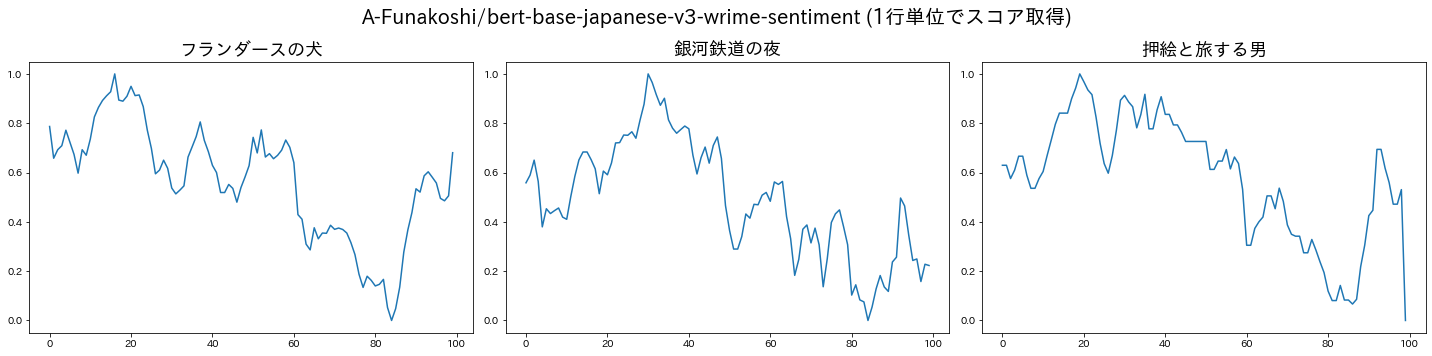

In [15]:
plt.figure(figsize=(20, 5))
plt.suptitle(f'{model_settings.model} ({SKIP_ROW}行単位でスコア取得)', fontsize=20)
for idx in np.arange(len(score_list)):
    plt.subplot(1, 3, idx+1)
    plt.title(novel_list[idx], fontsize=18)
    plt.plot(score_list[idx])
plt.tight_layout()